In [1]:
import numpy as np
import os
from time import time
import datetime
import gc
import re

import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, auc, normalized_mutual_info_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from matplotlib import pyplot as plt
from matplotlib import colors
import pydotplus


import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
from tensorboard.plugins.hparams import api as hp

from read_dataset_for_constraint import switch_dataset, data_to_interpret

from utils import plot_boundaries_hyperrect
from sTGMA import SoftTruncatedGaussianMixtureAnalysis

from black_box import BlackBoxNN
from config import  config_params, hyper_params


ImportError: cannot import name 'plot_tree'

In [155]:
datasets = ["data1", "wine", "bank_marketing", "ionosphere", "magic_gamma", "pima_indian_diabetes", "indian_liver", "german_credit", "heart_disease", "adult", "breast_cancer", "thoracy_surgery","winequality_red", "waveform", "credit_card", "news_popularity"]

In [156]:
dico_results = {name: pd.DataFrame(columns=["fold", "train_acc_DT", "test_acc_DT", "K"]) for name in datasets}

In [157]:
for fold in range(5):
    for dataset_name in ['news_popularity']:
        
        data_train = np.genfromtxt(f'data_global/{dataset_name}/{dataset_name}_train_{fold}.csv',delimiter=';')

        data_test = np.genfromtxt(f'data_global/{dataset_name}/{dataset_name}_val_{fold}.csv',delimiter=';')

        X_train = data_train[:,:-1].astype(np.float32)

        y_train = data_train[:,-1]

        X_test = data_test[:,:-1].astype(np.float32)

        y_test = data_test[:,-1]
        list_accuracy = []
        for depth in range(2,6):
            dt = DecisionTreeClassifier(max_depth=depth, random_state=111)
            dt.fit(X_train, y_train)
            list_accuracy.append(accuracy_score(y_test, dt.predict(X_test)))
        dt = DecisionTreeClassifier(max_depth=2+np.argmax(list_accuracy), random_state=111)
        data_train = np.genfromtxt(f'data_global/{dataset_name}/{dataset_name}_holdout_train_{fold}.csv',delimiter=';')

        data_test = np.genfromtxt(f'data_global/{dataset_name}/{dataset_name}_holdout_test_{fold}.csv',delimiter=';')

        X_train = data_train[:,:-1].astype(np.float32)

        y_train = data_train[:,-1]

        X_test = data_test[:,:-1].astype(np.float32)
        y_test = data_test[:,-1]
        
        dt.fit(X_train, y_train)
        
        dico_results[dataset_name].loc[fold] = [fold, accuracy_score(dt.predict(X_train), y_train), accuracy_score(dt.predict(X_test), y_test), 2+np.argmax(list_accuracy)]

In [158]:
mean_results = pd.DataFrame(columns=["test_acc", "train_acc"])

In [159]:
for name in datasets:
    mean_results.loc[name] = [ dico_results[name]["test_acc_DT"].mean(), dico_results[name]["train_acc_DT"].mean()]

In [143]:
mean_results

,test_acc,train_acc
data1,0.833333,0.968085
wine,0.911111,0.971831
bank_marketing,0.912136,0.917876
ionosphere,0.873239,0.939286
magic_gamma,0.825657,0.838420
pima_indian_diabetes,0.724675,0.817264
indian_liver,0.660345,0.765011
german_credit,0.718000,0.771500
heart_disease,0.753333,0.866667
adult,0.855953,0.859934


In [160]:
dico_results['news_popularity']

,fold,train_acc_DT,test_acc_DT,K
0,0.0,0.644994,0.641821,5.0
1,1.0,0.639477,0.617606,4.0
2,2.0,0.647328,0.629840,5.0
3,3.0,0.646697,0.632741,5.0
4,4.0,0.649157,0.630975,5.0


In [29]:
mean_results

,test_acc,train_acc
data1,0.833333,0.968085
wine,0.911111,0.971831
bank_marketing,0.912136,0.917876
ionosphere,0.873239,0.939286
magic_gamma,0.825657,0.838420
pima_indian_diabetes,0.724675,0.817264
indian_liver,0.660345,0.765011
german_credit,0.718000,0.771500
heart_disease,0.753333,0.866667
adult,0.855953,0.859934


In [3]:
import daft
from matplotlib import rc
# import matplotlib as mpl
# rc_fonts = {"font.size":40,
#             "font.family":"serif",
#             'figure.titlesize': 22,
#     'text.latex.preamble': [r"""\usepackage{bm}"""],
#              "xtick.labelsize": 20,
#     "ytick.labelsize": 20,
# }

# mpl.rcParams.update(rc_fonts)





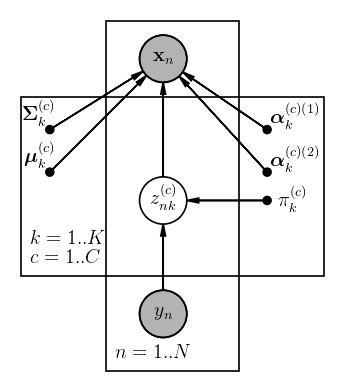

In [56]:

rc("font", family="serif", size=12)
rc("text", usetex=True)


# Instantiate the PGM.
pgm = daft.PGM()

# Hierarchical parameters.
# pgm.add_node("alpha", r"$\alpha$", 0.5, 2, fixed=True)
# pgm.add_node("beta", r"$\beta$", 1.5, 2)

# Latent variable.
pgm.add_node("z", r"$z_{nk}^{(c)}$", 1.5, 2)

# Data.
pgm.add_node("x", r"$\mathbf{x}_n$", 1.5, 3.5, observed=True)
pgm.add_node("y", r"$y_n$", 1.5, 0.8, observed=True)
pgm.add_node("pi", r"$\pi^{(c)}_k$", 2.6, 2, fixed = True,offset=(15,-12))
pgm.add_node("sigma", r"$\mathbf{\Sigma}^{(c)}_k$", 0.3, 2.75, fixed=True, offset=(-6,-3))
pgm.add_node("mu", r'$\textrm{\boldmath$\mu$}^{(c)}_k$', 0.3, 2.3, fixed=True, offset=(-6,-3))
pgm.add_node("alpha1", r"$\textrm{\boldmath$\alpha$}^{(c)(1)}_k$", 2.6, 2.75, fixed=True , offset=(17,-5))
pgm.add_node("alpha2", r"$\textrm{\boldmath$\alpha$}^{(c)(2)}_k$", 2.6, 2.3, fixed=True, offset=(17,-5))
# Add in the edges.
pgm.add_edge("y", "z")
pgm.add_edge("z", "x")
pgm.add_edge("pi", "z")
pgm.add_edge("mu", "x")
pgm.add_edge("alpha1", "x")
pgm.add_edge("alpha2", "x")
pgm.add_edge("sigma", "x")
# And a plate.
pgm.add_plate([0.9, 0.4, 1.4, 3.5], label=r"$n=1..N$", shift=-0.2)
pgm.add_plate([0, 1.4, 3.2, 1.7], label=r"$\\k=1..K\\ c=1..C$", shift=-0.2)

# Render and save.
pgm.render(dpi=120)


pgm.savefig("strugma.png", dpi=120)

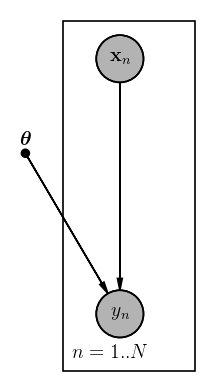

In [57]:
# Instantiate the PGM.
pgm1 = daft.PGM()


# Data.
pgm1.add_node("x", r"$\mathbf{x}_n$", 1.5, 3.5, observed=True)
pgm1.add_node("y", r"$y_n$", 1.5, 0.8, observed=True)


pgm1.add_node("theta", r'$\textrm{\boldmath$\theta$}$', 0.5, 2.5, fixed=True)

# Add in the edges.
pgm1.add_edge("x", "y")
pgm1.add_edge("theta", "y")

# And a plate.
pgm1.add_plate([0.9, 0.4, 1.4, 3.5], label=r"$n=1..N$", shift=-0.2)


# Render and save.
pgm1.render(dpi=120)


pgm1.savefig("black_box.png", dpi=120)

In [29]:
X_train_exp = binarise(lower, upper, X_train)

X_test_exp = binarise(lower, upper, X_test)

bb_y_train = np.argmax(black_box.predict(X_train).numpy(), axis = -1)
bb_y_test =  np.argmax(black_box.predict(X_test).numpy(), axis = -1)
print(accuracy_score(bb_y_test, y_test))

bb_y_train_2 = np.argmax(black_box2.predict(X_train).numpy(), axis = -1)
bb_y_test_2 =  np.argmax(black_box2.predict(X_test).numpy(), axis = -1)
print(accuracy_score(bb_y_test_2, y_test))



0.9166666666666666


ValueError: Could not find matching function to call loaded from the SavedModel. Got:
  Positional arguments (1 total):
    * Tensor("X:0", shape=(75, 2), dtype=float32)
  Keyword arguments: {}

Expected these arguments to match one of the following 2 option(s):

Option 1:
  Positional arguments (1 total):
    * TensorSpec(shape=(24, 2), dtype=tf.float32, name='X')
  Keyword arguments: {}

Option 2:
  Positional arguments (1 total):
    * TensorSpec(shape=(94, 2), dtype=tf.float32, name='X')
  Keyword arguments: {}

In [154]:
X_train_exp[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

In [13]:
n_min = min(5,round(X_train.shape[0]/90))

#n_min = 2

In [157]:
metrics_without = pd.read_csv(f"images_black_box_NN/datasets/{dataset_name}_{fold}/{dataset_name}.csv")
metrics_with = pd.read_csv(f"{location_co}/{dataset_name}_{hyper_params[dataset_name][1]}_{hyper_params[dataset_name][0]}_holdout.csv")

In [156]:
indices = np.random.RandomState(seed=111).permutation(X_train.shape[0])
ind_train = indices[0:int(0.8* len(indices))]
ind_val = indices[int(0.8*len(indices)):]

result_metrics_V = {"fidel_without":[], "fidel_BB_DT": [], "fidel_BB_STGMA_DT": [], 
                  'depth' : []}
acc_bb_without = accuracy_score(bb_y_test_2, y_test)
acc_bb_with = accuracy_score(bb_y_test, y_test)
for K in range(2, 6):
    
    dt1 = DecisionTreeClassifier(max_depth = K,random_state=111, min_samples_leaf=n_min)

    dt1.fit(X_train[ind_train], y_train[ind_train])
    dt2 = DecisionTreeClassifier(max_depth=K, random_state = 111, min_samples_leaf=n_min)

    dt2.fit(X_train_exp[ind_train], bb_y_train[ind_train])

    dt4 = DecisionTreeClassifier(max_depth=K,  random_state = 111, min_samples_leaf=n_min)

    dt4.fit(X_train[ind_train], bb_y_train[ind_train])

    dt5 = DecisionTreeClassifier(max_depth=K, random_state = 111, min_samples_leaf=n_min)

    dt5.fit(X_train[ind_train], bb_y_train_2[ind_train])
    
    result_metrics_V['depth'].append(K)
    result_metrics_V["fidel_without"].append(accuracy_score(dt5.predict(X_train[ind_val]), bb_y_train_2[ind_val]))
    result_metrics_V["fidel_BB_DT"].append(accuracy_score(dt4.predict(X_train[ind_val]), bb_y_train[ind_val]))
    result_metrics_V["fidel_BB_STGMA_DT"].append(accuracy_score(dt2.predict(X_train_exp[ind_val]), bb_y_train[ind_val]))
    

In [32]:
indices = np.random.RandomState(seed=111).permutation(X_train.shape[0])
ind_train = indices[0:int(0.8* len(indices))]
ind_val = indices[int(0.8*len(indices)):]


result_metrics_V = {"accuracy":[], 
                  'depth' : []}
for K in range(2, 6):
    
    dt1 = DecisionTreeClassifier(max_depth = K,random_state=111, min_samples_leaf=n_min)

    dt1.fit(X_train[ind_train], y_train[ind_train])
  
    
    result_metrics_V['depth'].append(K)
    result_metrics_V["accuracy"].append(accuracy_score(dt1.predict(X_train[ind_val]), y_train[ind_val]))

dt1 = DecisionTreeClassifier(max_depth=result_metrics_V["depth"][np.argmax(result_metrics_V["accuracy"])],
                                 min_samples_leaf=n_min, random_state=111)

dt1.fit(X_train, y_train)
print(result_metrics_V["depth"][np.argmax(result_metrics_V["accuracy"])])
print(accuracy_score(dt1.predict(X_train), y_train))
print(accuracy_score(dt1.predict(X_test), y_test))

2
0.9466666666666667
0.9583333333333334


In [158]:
result_metrics_V

{'fidel_without': [0.9024390243902439,
  0.8943089430894309,
  0.9024390243902439,
  0.8943089430894309],
 'fidel_BB_DT': [0.8861788617886179,
  0.926829268292683,
  0.9105691056910569,
  0.926829268292683],
 'fidel_BB_STGMA_DT': [0.943089430894309,
  0.959349593495935,
  0.967479674796748,
  0.967479674796748],
 'depth': [2, 3, 4, 5]}

In [159]:
result_metrics = {"fidel_without":[], "fidel_BB_DT": [], "fidel_BB_STGMA_DT": [], 'depth' : []}
acc_bb_without = accuracy_score(bb_y_test_2, y_test)
acc_bb_with = accuracy_score(bb_y_test, y_test)

dt2 = DecisionTreeClassifier(max_depth=result_metrics_V["depth"][np.argmax(result_metrics_V["fidel_BB_STGMA_DT"])],
                                 min_samples_leaf=n_min, random_state=111)

dt2.fit(X_train_exp, bb_y_train)

dt4 = DecisionTreeClassifier(max_depth=result_metrics_V["depth"][np.argmax(result_metrics_V["fidel_BB_DT"])], 
                                 min_samples_leaf=n_min, random_state=111)

dt4.fit(X_train, bb_y_train)

dt5 = DecisionTreeClassifier(max_depth=result_metrics_V["depth"][np.argmax(result_metrics_V["fidel_without"])], min_samples_leaf=n_min, 
                             random_state=111)

dt5.fit(X_train, bb_y_train_2)
    

result_metrics["fidel_without"].append(accuracy_score(dt5.predict(X_test), bb_y_test_2))
result_metrics["fidel_BB_DT"].append(accuracy_score(dt4.predict(X_test), bb_y_test))
result_metrics["fidel_BB_STGMA_DT"].append(accuracy_score(dt2.predict(X_test_exp), bb_y_test))

In [160]:
result_metrics

{'fidel_without': [0.8311688311688312],
 'fidel_BB_DT': [0.9090909090909091],
 'fidel_BB_STGMA_DT': [0.8571428571428571],
 'depth': []}

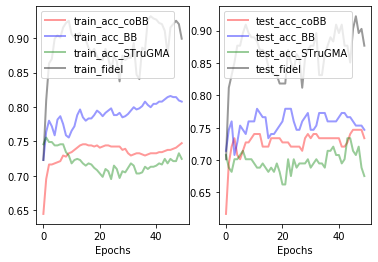

In [161]:
N = min(metrics_with.shape[0], metrics_without.shape[0])
plt.subplot(1, 2, 1)
plt.plot(metrics_with["train_acc_bb"][:N], color='red', alpha = 0.4, label="train_acc_coBB", linewidth=2.)
plt.plot(metrics_without["train_acc_bb"][:N], color='blue', alpha = 0.4, label="train_acc_BB", linewidth=2.)
plt.plot(metrics_with["train_acc_stgma"][:N], color='green', alpha = 0.4, label="train_acc_STruGMA", linewidth=2.)
plt.plot(metrics_with["train_fidel"][:N], color='black', alpha = 0.4, label="train_fidel", linewidth=2.)
plt.xlabel("Epochs")
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(metrics_with["test_acc_bb"][:N], color='red', alpha = 0.4, label="test_acc_coBB", linewidth=2.)
plt.plot(metrics_without["test_acc_bb"][:N], color='blue', alpha = 0.4, label="test_acc_BB", linewidth=2.)
plt.plot(metrics_with["test_acc_stgma"][:N], color='green', alpha = 0.4, label="test_acc_STruGMA", linewidth=2.)
plt.plot(metrics_with["test_fidel"][:N], color='black', alpha = 0.4, label="test_fidel", linewidth=2.)
plt.xlabel("Epochs")
#plt.scale('log')
plt.legend()
#plt.legend(ncol = 4)
plt.savefig(f"results/{dataset_name}_curves.png", bbox_inches = 'tight', pad_inches = 0, dpi=300)

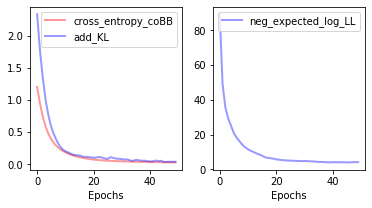

In [130]:
N = min(metrics_with.shape[0], metrics_without.shape[0])
plt.figure(figsize=(6,3))
plt.subplot(1, 2, 1)
plt.plot(metrics_with["cross_entropy"][:N], color='red', alpha = 0.4, label="cross_entropy_coBB", linewidth=2.)
plt.plot(metrics_with["shareloss1"][:N], color='blue', alpha = 0.4, label="add_KL", linewidth=2.)

plt.xlabel("Epochs")
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(metrics_with["expected_loglikel"][:N], color='blue', alpha = 0.4, label="neg_expected_log_LL", linewidth=2.)

plt.xlabel("Epochs")
#plt.scale('log')

plt.legend()
plt.savefig(f"results/{dataset_name}_losses_c_bis.png", bbox_inches = 'tight', pad_inches = 0, dpi=300)

In [53]:
scaler.mean_

array([3.325e+00, 4.638e+00, 6.221e+01, 3.333e-03, 1.100e-01, 7.767e-01,
       7.333e-02, 2.333e-02, 1.333e-02, 0.000e+00, 2.867e-01, 6.767e-01,
       3.667e-02, 9.400e-01, 6.000e-02, 8.633e-01, 1.367e-01, 9.367e-01,
       6.333e-02, 3.000e-01, 7.000e-01, 8.600e-01, 1.400e-01, 3.600e-01,
       5.400e-01, 5.000e-02, 5.000e-02, 9.233e-01, 7.667e-02, 9.933e-01,
       6.667e-03, 9.833e-01, 1.667e-02, 1.833e-01, 8.167e-01, 9.933e-01,
       6.667e-03])

In [54]:
graph = export_graphviz(dt1, filled=True, feature_names=column_names[:-1])
graph = pydotplus.graph_from_dot_data(graph)
graph.write_png(f'trees/dt1_{dataset_name}.png') 

True

In [55]:
graph = export_graphviz(dt2, filled=True, feature_names=columns_lower + columns_upper)
export_graphviz(dt2, filled=True, out_file="trees/outfile2.dot", feature_names=columns_lower + columns_upper)
graph=pydotplus.graph_from_dot_data(graph)
graph.write_png(f'trees/dt2_{dataset_name}_bis.png') 

True

In [34]:
graph = export_graphviz(dt4, filled=True, feature_names=column_names[:-1])
graph=pydotplus.graph_from_dot_data(graph)
graph.write_png(f'trees/dt4_{dataset_name}.png') 

AttributeError: 'str' object has no attribute 'render'

In [18]:
graph=export_graphviz(dt1, filled=True, feature_names=column_names[:-1])
graph=pydotplus.graph_from_dot_data(graph)
graph.write_png(f'trees/dt5_{dataset_name}.png') 

True

In [31]:
accuracy_score(dt5.predict(X_test),y_test)

0.8333333333333334

In [28]:
accuracy_score(dt5.predict(X_test), y_test)

0.8333333333333334

In [32]:
accuracy_score(dt4.predict(X_test), y_test)

0.8166666666666667

In [33]:
accuracy_score(dt2.predict(X_test_exp), y_test)

0.8

In [34]:
accuracy_score(bb_y_test, y_test)

0.8333333333333334

In [26]:
accuracy_score(dt1.predict(X_test), y_test)

0.8

In [ ]:
K= 4
dt1 = DecisionTreeClassifier(max_depth = K, min_samples_leaf=n_min)

dt1.fit(X_train, y_train)

dt2 = DecisionTreeClassifier(max_depth=K, min_samples_leaf=n_min)

dt2.fit(X_train_exp, bb_y_train)

dt4 = DecisionTreeClassifier(max_depth=K, min_samples_leaf=n_min)

dt4.fit(X_train, bb_y_train)

dt5 = DecisionTreeClassifier(max_depth=K, min_samples_leaf=n_min)

dt5.fit(X_train, bb_y_train_2)

In [35]:
import weka.core.jvm as jvm
jvm.start()


DEBUG:weka.core.jvm:Adding bundled jars
DEBUG:weka.core.jvm:Classpath=['/home/gnanfack/.local/lib/python3.6/site-packages/javabridge/jars/rhino-1.7R4.jar', '/home/gnanfack/.local/lib/python3.6/site-packages/javabridge/jars/runnablequeue.jar', '/home/gnanfack/.local/lib/python3.6/site-packages/javabridge/jars/cpython.jar', '/home/gnanfack/.local/lib/python3.6/site-packages/weka/lib/python-weka-wrapper.jar', '/home/gnanfack/.local/lib/python3.6/site-packages/weka/lib/weka.jar']
DEBUG:weka.core.jvm:MaxHeapSize=default
DEBUG:weka.core.jvm:Package support disabled


In [157]:
from weka.core.dataset import create_instances_from_matrices
from weka.classifiers import Classifier, Evaluation
import weka.plot.classifiers as plot_cls
import weka.plot.graph as plot_graph
from weka.filters import Filter
cls = Classifier(classname="weka.classifiers.rules.JRip", options=["-N", f"{str(n_min)}", "-P"])

In [164]:
dataset = create_instances_from_matrices(X_train, bb_y_train, name="generated from matrices")
dataset.class_is_last()


nominal = Filter(classname="weka.filters.unsupervised.attribute.NumericToNominal", options=["-R", "last"])
nominal.inputformat(dataset)
nominaldata1 = nominal.filter(dataset)
nominaldata1.class_is_last()

cls.build_classifier(nominaldata1)

In [165]:
print(cls)


JRIP rules:

(x2 >= 0.680699) and (x6 >= -0.252935) => y=1 (117.0/0.0)
(x2 >= 0.437074) and (x1 >= 0.333032) => y=1 (27.0/0.0)
(x2 >= 0.162996) and (x6 >= 0.512967) and (x4 >= 0.356128) => y=1 (17.0/0.0)
(x2 >= 1.046137) => y=1 (8.0/0.0)
(x6 >= -0.559295) and (x2 >= 0.650246) and (x1 >= -0.54768) => y=1 (7.0/0.0)
 => y=0 (438.0/15.0)

Number of Rules : 6



In [168]:
dataset = create_instances_from_matrices(X_test, bb_y_test, name="Test")
dataset.class_is_last()


nominal = Filter(classname="weka.filters.unsupervised.attribute.NumericToNominal", options=["-R", "last"])
nominal.inputformat(dataset)
nominaldata1 = nominal.filter(dataset)
nominaldata1.class_is_last()

In [169]:
evaluation = Evaluation(nominaldata1)
evl = evaluation.test_model(cls, nominaldata1)

print(evaluation.summary())


Correctly Classified Instances         146               94.8052 %
Incorrectly Classified Instances         8                5.1948 %
Kappa statistic                          0.8709
Mean absolute error                      0.0749
Root mean squared error                  0.2259
Relative absolute error                 18.5389 %
Root relative squared error             50.3457 %
Total Number of Instances              154     



In [88]:
plt.rcParams["figure.figsize"] = (9,6.75)

X1 = X_train[:,0]
X2 = X_train[:,1]
steps = 1000
cmap = colors.ListedColormap(list(color_map.values())[:len(np.unique(y_train))])
# Define region of interest by data limits
deltaX = (max(X1) - min(X1))/10
deltaY = (max(X2) - min(X2))/10

xmin, xmax = min(X1) - deltaX, max(X1) + deltaX
ymin, ymax = min(X2) - deltaY, max(X2) + deltaY

x_span = np.linspace(xmin, xmax, steps)
y_span = np.linspace(ymin, ymax, steps)
xx, yy = np.meshgrid(x_span, y_span)

# Make predictions across region of interest
labels_dt = dt4.predict(np.c_[xx.ravel(), yy.ravel()])
#labels_dt = np.argmax(labels_bb, axis = 1)

#plt.subplot(2, 1, 1)
z1 = labels_dt.reshape(xx.shape)
ranges = np.linspace(z1.min(), z1.max(), len(color_map.values())+1)
norm = colors.BoundaryNorm(ranges, cmap.N)


plt.contourf(xx, yy, z1, alpha=0.2, cmap = cmap, norm=norm)

plt.scatter(X1, X2, c = [color_map[y_train[i]] for i in range(X_train.shape[0])],  edgecolor='k', lw=0, cmap="Set1")
currentAxis = plt.gca()

plt.savefig(f"dt_post_hoc.png")
plt.clf()

<Figure size 648x486 with 0 Axes>

In [90]:
X1 = X_train[:,0]
X2 = X_train[:,1]
steps = 1000
plt.rcParams["figure.figsize"] = (9,6.75)
cmap = colors.ListedColormap(list(color_map.values())[:len(np.unique(y_train))])
# Define region of interest by data limits
deltaX = (max(X1) - min(X1))/10
deltaY = (max(X2) - min(X2))/10

xmin, xmax = min(X1) - deltaX, max(X1) + deltaX
ymin, ymax = min(X2) - deltaY, max(X2) + deltaY

x_span = np.linspace(xmin, xmax, steps)
y_span = np.linspace(ymin, ymax, steps)
xx, yy = np.meshgrid(x_span, y_span)

# Make predictions across region of interest
labels_dt = dt2.predict(binarise(lower, upper,np.c_[xx.ravel(), yy.ravel()]))
#labels_dt = np.argmax(labels_bb, axis = 1)

#plt.subplot(2, 1, 1)
z1 = labels_dt.reshape(xx.shape)
ranges = np.linspace(z1.min(), z1.max(), len(color_map.values())+1)
norm = colors.BoundaryNorm(ranges, cmap.N)


plt.contourf(xx, yy, z1, alpha=0.2, cmap = cmap, norm=norm)

plt.scatter(X1, X2, c = [color_map[y_train[i]] for i in range(X_train.shape[0])],  edgecolor='k', lw=0, cmap="Set1")
currentAxis = plt.gca()

plt.savefig(f"dt_post_hoc_with_regul.png")
plt.clf()

<Figure size 648x486 with 0 Axes>

In [24]:
dataset_name = "student_performance"    

X_train, y_train, X_test, y_test, y_train_onehot, y_test_onehot, scaler, color_map, column_names = \
        data_to_interpret(dataset_name, 0)

location_without = f"images_black_box_NN/datasets/{dataset_name}_0/bb_weights"
black_box2 = tf.saved_model.load(location_without)

dt5 = DecisionTreeClassifier(max_depth=3, min_samples_leaf=2)
bb_y_train_2 = np.argmax(black_box2.predict(X_train).numpy(), axis = -1)
bb_y_test_2 =  np.argmax(black_box2.predict(X_test).numpy(), axis = -1)
dt5.fit(X_train, bb_y_train_2)
accuracy_score(dt5.predict(X_test), bb_y_test_2)

1.0

In [25]:
dt1 = DecisionTreeClassifier(max_depth = 3, min_samples_leaf=2)

dt1.fit(X_train, y_train)
print(accuracy_score(dt1.predict(X_train), y_train))
print(accuracy_score(dt1.predict(X_test), y_test))

1.0
1.0


In [31]:
column_names

['duration_month',
 'credit_amount',
 'installment_rate',
 'residence_since',
 'age',
 'number_of_existing_credits',
 'number_people_maintenance',
 'Class',
 'status_account_A11',
 'status_account_A12',
 'status_account_A13',
 'status_account_A14',
 'credit_history_A30',
 'credit_history_A31',
 'credit_history_A32',
 'credit_history_A33',
 'credit_history_A34',
 'purpose_A40',
 'purpose_A41',
 'purpose_A410',
 'purpose_A42',
 'purpose_A43',
 'purpose_A44',
 'purpose_A45',
 'purpose_A46',
 'purpose_A48',
 'purpose_A49',
 'savings_account_A61',
 'savings_account_A62',
 'savings_account_A63',
 'savings_account_A64',
 'savings_account_A65',
 'present_employment_since_A71',
 'present_employment_since_A72',
 'present_employment_since_A73',
 'present_employment_since_A74',
 'present_employment_since_A75',
 'personal_status_sex_A91',
 'personal_status_sex_A92',
 'personal_status_sex_A93',
 'personal_status_sex_A94',
 'other_debtors_A101',
 'other_debtors_A102',
 'other_debtors_A103',
 'propert